# Training a neural network with McSnow output

This script applies a DNN to a regression problem 

Much of this follows the basic regression example from the Tensorflow tutorial

https://www.tensorflow.org/tutorials/keras/regression


In [1]:
version  = '17'

### Load Tensorflow and other useful modules

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

import pathlib

import pandas as pd
import seaborn as sns

import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt

print(tf.__version__)

2.1.0


In [3]:
tf.random.set_seed(1234)

### Load data from netcdf

In [4]:
import numpy as np
import xarray as xr

In [5]:
mdir='/Users/axel/DWD/GITLAB/mcsnow/'
edir='experiments/'

fname1=mdir+edir+'icebox_train_rc_ice.nc'

ds1 = xr.open_dataset(fname1)
print('ds1: ', ds1)

ds1:  <xarray.Dataset>
Dimensions:                        (cell: 2483775)
Dimensions without coordinates: cell
Data variables: (12/204)
    time                           (cell) float32 ...
    q_cloud                        (cell) float32 ...
    n_cloud                        (cell) float32 ...
    q_rain                         (cell) float32 ...
    n_rain                         (cell) float32 ...
    q_ice                          (cell) float32 ...
    ...                             ...
    frze_graupel_rain_mass         (cell) float32 ...
    frze_graupel_rain_rmass        (cell) float32 ...
    frze_graupel_rain_rvol         (cell) float32 ...
    frze_graupel_rain_liq          (cell) float32 ...
    rime_graupel_rain_num          (cell) float32 ...
    rime_graupel_rain_mass         (cell) float32 ...
Attributes:
    title:    McSnow ice microphysics box model output pre-processed by NCL
    date:     Mo 30 Mai 2022 00:45:20 CEST
    nfiles:   10013


# Prepare data for training

In [6]:
def read_and_prepare_data(fname):
    # Read some data, we just want simple nparrays. Hence the .values
    temp = xr.open_dataset(fname).temp.values
    rho  = xr.open_dataset(fname).rho.values
    qi   = xr.open_dataset(fname).q_ice.values
    ni   = xr.open_dataset(fname).n_ice.values
    ssi  = xr.open_dataset(fname).ssi.values
    cwc  = xr.open_dataset(fname).cwc.values
    # process rates
    vel_num  = xr.open_dataset(fname).ice_vel_num.values
    vel_mass = xr.open_dataset(fname).ice_vel_mass.values
    # some numerical lower bounds
    q_min = 1e-12
    n_min = 1e-12
    z_min = 1e-20
    p_min = 1e-20
    # transform everything in log space
    ni = np.log(ni, where=ni>n_min, out=np.nan*ni)
    qi = np.log(qi, where=qi>q_min, out=np.nan*qi)
    vel_num  = np.log(vel_num,  where=vel_num>p_min, out=np.nan*vel_num)    
    vel_mass = np.log(vel_mass, where=vel_mass>p_min, out=np.nan*vel_mass)
    # put everything in a pandas dataframe
    dataset = pd.DataFrame(np.array( [ qi, ni, temp, rho, ssi, vel_num, vel_mass ]))
    dataset = dataset.T
    dataset.columns = [ 'qi', 'ni', 'temp', 'rho', 'ssi', 'vel_num', 'vel_mass' ] 
    # remove missing values immediately
    dataset = dataset.dropna()
    return dataset

In [7]:
df = read_and_prepare_data(fname1)

### Split in training, testing and validation with 70/15/15 rule

In [8]:
msk = np.random.rand(len(df)) < 0.7
dataset_train = df[msk]

df2 = df[~msk]
msk = np.random.rand(len(df2)) < 0.5

dataset_test = df2[msk]
dataset_val = df2[~msk]

### Inspect the data

In [9]:
dataset_train.head()

qi         ni        temp    rho     ssi   vel_num  vel_mass
0 -9.095227  11.626968  243.639999  0.698  0.0098 -1.715354 -1.261602
1 -9.098263  11.622676  243.710007  0.699  0.0098 -1.713688 -1.263015
2 -9.102742  11.618186  243.779999  0.700  0.0098 -1.712579 -1.265494
3 -9.107783  11.613495  243.850006  0.701  0.0098 -1.711471 -1.268334
4 -9.112307  11.609235  243.929993  0.702  0.0098 -1.710364 -1.270825

In [10]:
dataset_train.describe()

qi            ni          temp           rho           ssi  \
count  1.738255e+06  1.738255e+06  1.738255e+06  1.738255e+06  1.738255e+06   
mean  -9.532087e+00  1.352413e+01  2.407711e+02  6.811443e-01  4.986754e-03   
std    3.252626e+00  3.879384e+00  1.311646e+01  1.610906e-01  1.648063e-02   
min   -2.302555e+01 -4.852273e+00  2.067200e+02  4.120000e-01 -6.100000e-03   
25%   -9.774048e+00  1.199972e+01  2.312300e+02  5.590000e-01  2.000000e-03   
50%   -8.679712e+00  1.418769e+01  2.405200e+02  6.630000e-01  2.900000e-03   
75%   -7.703201e+00  1.624022e+01  2.490700e+02  7.680000e-01  3.900000e-03   
max   -4.315790e+00  2.052169e+01  2.737800e+02  1.288000e+00  3.019000e-01   

            vel_num      vel_mass  
count  1.738255e+06  1.738255e+06  
mean  -2.851835e+00 -2.503214e+00  
std    8.237187e-01  7.507607e-01  
min   -7.012228e+00 -5.863247e+00  
25%   -3.425900e+00 -3.053573e+00  
50%   -2.778204e+00 -2.492898e+00  
75%   -2.214574e+00 -1.902467e+00  
max    2.021242e-01  2.102609e-01

In [11]:
dataset_test.describe()

qi             ni           temp            rho  \
count  372829.000000  372829.000000  372829.000000  372829.000000   
mean       -9.537120      13.518775     240.789536       0.681233   
std         3.254015       3.879489      13.100989       0.160986   
min       -23.025551      -4.446544     207.139999       0.412000   
25%        -9.786665      11.991827     231.259995       0.560000   
50%        -8.682244      14.183619     240.559998       0.663000   
75%        -7.705241      16.234634     249.070007       0.769000   
max        -4.325495      20.520414     273.809998       1.283000   

                 ssi        vel_num       vel_mass  
count  372829.000000  372829.000000  372829.000000  
mean        0.004990      -2.851661      -2.503425  
std         0.016537       0.825928       0.752651  
min        -0.006300      -6.713011      -5.830026  
25%         0.000900      -3.425593      -3.051879  
50%         0.002900      -2.779009      -2.494472  
75%         0.003900      -2.210006      -1.899790  
max         0.300200       0.089841       0.092579

In [12]:
dataset_val.describe()

qi             ni           temp            rho  \
count  372691.000000  372691.000000  372691.000000  372691.000000   
mean       -9.530787      13.527118     240.754700       0.680917   
std         3.256984       3.885854      13.116107       0.161107   
min       -23.024052      -4.158947     206.649994       0.412000   
25%        -9.766992      12.008841     231.190002       0.559000   
50%        -8.678301      14.198935     240.500000       0.662000   
75%        -7.699331      16.241817     249.050003       0.768000   
max        -4.363165      20.517740     273.820007       1.284000   

                 ssi        vel_num       vel_mass  
count  372691.000000  372691.000000  372691.000000  
mean        0.005005      -2.852366      -2.504586  
std         0.016505       0.824891       0.752105  
min        -0.006400      -6.709724      -5.838915  
25%         0.002000      -3.424978      -3.054421  
50%         0.002900      -2.779976      -2.495685  
75%         0.003900      -2.213659      -1.901798  
max         0.302800       0.068593       0.076035

### Further reduce data to relevant parameter range

In [13]:
def reduce_data(dataset):
    idx = dataset[ dataset['qi'] < -20 ].index
    dataset.drop(idx,inplace=True)   
    idx = dataset[ dataset['ni'] < -1 ].index
    dataset.drop(idx,inplace=True)   
    idx = dataset[ dataset['vel_num'] < -3 ].index
    dataset.drop(idx,inplace=True)   
    idx = dataset[ dataset['vel_mass'] < -3 ].index
    dataset.drop(idx,inplace=True)   
    idx = dataset[ dataset['temp'] > 273 ].index
    dataset.drop(idx,inplace=True)   
    return dataset

In [14]:
dataset_test  = reduce_data(dataset_test)
dataset_train = reduce_data(dataset_train)
dataset_val   = reduce_data(dataset_val)

/usr/local/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [15]:
dataset_train.describe()

qi             ni           temp            rho  \
count  979504.000000  979504.000000  979504.000000  979504.000000   
mean       -9.741601      12.304664     242.852997       0.704176   
std         2.549188       2.911477      12.733965       0.157609   
min       -19.999977      -0.980829     206.720001       0.412000   
25%       -10.091989      11.398566     234.210007       0.589000   
50%        -9.029603      12.926810     243.270004       0.696000   
75%        -8.294720      14.214488     251.229996       0.797000   
max        -4.356905      18.221474     273.000000       1.279000   

                 ssi        vel_num       vel_mass  
count  979504.000000  979504.000000  979504.000000  
mean        0.006405      -2.296182      -2.005693  
std         0.019994       0.422253       0.442072  
min         0.000000      -2.999941      -2.999339  
25%         0.002300      -2.666141      -2.350725  
50%         0.003200      -2.331808      -2.012157  
75%         0.005600      -1.974721      -1.653912  
max         0.301900      -0.606786      -0.600750

In [16]:
dataset_test.describe()

qi             ni           temp            rho  \
count  209552.000000  209552.000000  209552.000000  209552.000000   
mean       -9.740686      12.301459     242.855484       0.704100   
std         2.542775       2.904641      12.706340       0.157336   
min       -19.999977      -0.980829     207.139999       0.412000   
25%       -10.096611      11.384484     234.220001       0.589000   
50%        -9.030438      12.920321     243.279999       0.696000   
75%        -8.299857      14.209443     251.210007       0.797000   
max        -4.477041      18.251778     273.000000       1.269000   

                 ssi        vel_num       vel_mass  
count  209552.000000  209552.000000  209552.000000  
mean        0.006427      -2.294022      -2.003805  
std         0.020080       0.422107       0.442309  
min         0.000000      -2.999941      -2.999339  
25%         0.002300      -2.663842      -2.349572  
50%         0.003200      -2.328929      -2.008424  
75%         0.005700      -1.973281      -1.651824  
max         0.300200      -0.606969      -0.600568

### Pairplot

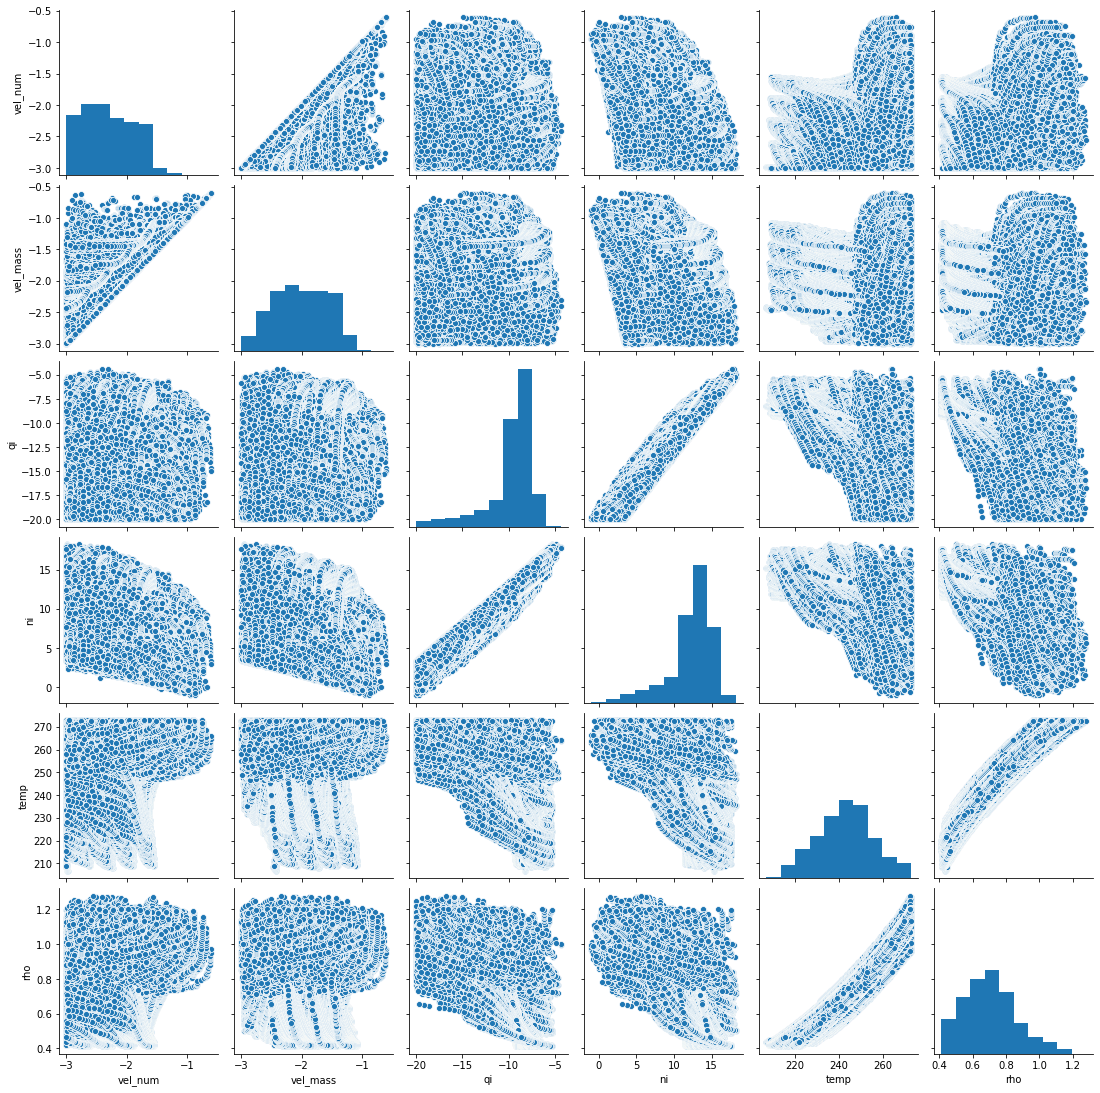

In [17]:
sns.pairplot(dataset_train[["vel_num","vel_mass","qi","ni","temp","rho"]], diag_kind="hist")

## Separate in different dataset with selected sets of predictors

In [18]:
train_dataset1 = dataset_train.copy()
train_dataset2 = dataset_train.copy()
train_dataset3 = dataset_train.copy()
train_dataset4 = dataset_train.copy()
train_dataset5 = dataset_train.copy()

In [19]:
test_dataset1 = dataset_test.copy()
test_dataset2 = dataset_test.copy()
test_dataset3 = dataset_test.copy()
test_dataset4 = dataset_test.copy()
test_dataset5 = dataset_test.copy()

In [20]:
val_dataset1 = dataset_val.copy()
val_dataset2 = dataset_val.copy()
val_dataset3 = dataset_val.copy()
val_dataset4 = dataset_val.copy()
val_dataset5 = dataset_val.copy()

In [21]:
train_dataset1 = train_dataset1.drop(['temp','rho','ssi'], axis=1)
train_dataset2 = train_dataset2.drop(['temp','ssi'], axis=1)
train_dataset3 = train_dataset3.drop(['ssi'], axis=1)
#train_dataset4 = train_dataset4.drop(['zi'], axis=1)
#train_dataset5 = train_dataset5.drop(['qs'], axis=1)

In [22]:
test_dataset1 = test_dataset1.drop(['temp','rho','ssi'], axis=1)
test_dataset2 = test_dataset2.drop(['temp','ssi'], axis=1)
test_dataset3 = test_dataset3.drop(['ssi'], axis=1)
#test_dataset4 = test_dataset4.drop(['zi'], axis=1)
#test_dataset5 = test_dataset5.drop(['qs'], axis=1)

In [23]:
val_dataset1 = val_dataset1.drop(['temp','rho','ssi'], axis=1)
val_dataset2 = val_dataset2.drop(['temp','ssi'], axis=1)
val_dataset3 = val_dataset3.drop(['ssi'], axis=1)
#val_dataset4 = val_dataset4.drop(['zi'], axis=1)
#val_dataset5 = val_dataset5.drop(['qs'], axis=1)

In [24]:
train_stats1 = train_dataset1.describe()
train_stats1.pop("vel_num")
train_stats1.pop("vel_mass")
train_stats1 = train_stats1.transpose()
train_stats1

count       mean       std        min        25%        50%        75%  \
qi  979504.0  -9.741601  2.549188 -19.999977 -10.091989  -9.029603  -8.294720   
ni  979504.0  12.304664  2.911477  -0.980829  11.398566  12.926810  14.214488   

          max  
qi  -4.356905  
ni  18.221474

In [25]:
train_stats2 = train_dataset2.describe()
train_stats2.pop("vel_num")
train_stats2.pop("vel_mass")
train_stats2 = train_stats2.transpose()
train_stats2

count       mean       std        min        25%        50%  \
qi   979504.0  -9.741601  2.549188 -19.999977 -10.091989  -9.029603   
ni   979504.0  12.304664  2.911477  -0.980829  11.398566  12.926810   
rho  979504.0   0.704176  0.157609   0.412000   0.589000   0.696000   

           75%        max  
qi   -8.294720  -4.356905  
ni   14.214488  18.221474  
rho   0.797000   1.279000

In [26]:
train_stats3 = train_dataset3.describe()
train_stats3.pop("vel_num")
train_stats3.pop("vel_mass")
train_stats3 = train_stats3.transpose()
train_stats3

count        mean        std         min         25%         50%  \
qi    979504.0   -9.741601   2.549188  -19.999977  -10.091989   -9.029603   
ni    979504.0   12.304664   2.911477   -0.980829   11.398566   12.926810   
temp  979504.0  242.852997  12.733965  206.720001  234.210007  243.270004   
rho   979504.0    0.704176   0.157609    0.412000    0.589000    0.696000   

             75%         max  
qi     -8.294720   -4.356905  
ni     14.214488   18.221474  
temp  251.229996  273.000000  
rho     0.797000    1.279000

In [27]:
train_stats4 = train_dataset4.describe()
train_stats4.pop("vel_num")
train_stats4.pop("vel_mass")
train_stats4 = train_stats4.transpose()
train_stats4

count        mean        std         min         25%         50%  \
qi    979504.0   -9.741601   2.549188  -19.999977  -10.091989   -9.029603   
ni    979504.0   12.304664   2.911477   -0.980829   11.398566   12.926810   
temp  979504.0  242.852997  12.733965  206.720001  234.210007  243.270004   
rho   979504.0    0.704176   0.157609    0.412000    0.589000    0.696000   
ssi   979504.0    0.006405   0.019994    0.000000    0.002300    0.003200   

             75%         max  
qi     -8.294720   -4.356905  
ni     14.214488   18.221474  
temp  251.229996  273.000000  
rho     0.797000    1.279000  
ssi     0.005600    0.301900

In [28]:
train_stats5 = train_dataset5.describe()
train_stats5.pop("vel_num")
train_stats5.pop("vel_mass")
train_stats5 = train_stats5.transpose()
train_stats5

count        mean        std         min         25%         50%  \
qi    979504.0   -9.741601   2.549188  -19.999977  -10.091989   -9.029603   
ni    979504.0   12.304664   2.911477   -0.980829   11.398566   12.926810   
temp  979504.0  242.852997  12.733965  206.720001  234.210007  243.270004   
rho   979504.0    0.704176   0.157609    0.412000    0.589000    0.696000   
ssi   979504.0    0.006405   0.019994    0.000000    0.002300    0.003200   

             75%         max  
qi     -8.294720   -4.356905  
ni     14.214488   18.221474  
temp  251.229996  273.000000  
rho     0.797000    1.279000  
ssi     0.005600    0.301900

### Split features from labels (here we need only one set of labels)

Separate the target value, or "label", from the features. This label is the value that you will train the model to predict.

In [29]:
# pop does not work for multiple columns, use copy instead

labels = ['vel_num','vel_mass']

train_labels = train_dataset1[labels].copy()
train_dataset1.drop(labels, axis=1, inplace=True)

test_labels = test_dataset1[labels].copy()
test_dataset1.drop(labels, axis=1, inplace=True)

val_labels = val_dataset1[labels].copy()
val_dataset1.drop(labels, axis=1, inplace=True)

In [30]:
train_dataset2.drop(labels, axis=1, inplace=True)
test_dataset2.drop(labels, axis=1, inplace=True)
val_dataset2.drop(labels, axis=1, inplace=True)

In [31]:
train_dataset3.drop(labels, axis=1, inplace=True)
test_dataset3.drop(labels, axis=1, inplace=True)
val_dataset3.drop(labels, axis=1, inplace=True)

In [32]:
train_dataset4.drop(labels, axis=1, inplace=True)
test_dataset4.drop(labels, axis=1, inplace=True)
val_dataset4.drop(labels, axis=1, inplace=True)

In [33]:
train_dataset5.drop(labels, axis=1, inplace=True)
test_dataset5.drop(labels, axis=1, inplace=True)
val_dataset5.drop(labels, axis=1, inplace=True)

In [34]:
train_labels.describe()

vel_num       vel_mass
count  979504.000000  979504.000000
mean       -2.296182      -2.005693
std         0.422253       0.442072
min        -2.999941      -2.999339
25%        -2.666141      -2.350725
50%        -2.331808      -2.012157
75%        -1.974721      -1.653912
max        -0.606786      -0.600750

In [35]:
train_dataset1.describe()

qi             ni
count  979504.000000  979504.000000
mean       -9.741601      12.304664
std         2.549188       2.911477
min       -19.999977      -0.980829
25%       -10.091989      11.398566
50%        -9.029603      12.926810
75%        -8.294720      14.214488
max        -4.356905      18.221474

In [36]:
train_dataset2.describe()

qi             ni            rho
count  979504.000000  979504.000000  979504.000000
mean       -9.741601      12.304664       0.704176
std         2.549188       2.911477       0.157609
min       -19.999977      -0.980829       0.412000
25%       -10.091989      11.398566       0.589000
50%        -9.029603      12.926810       0.696000
75%        -8.294720      14.214488       0.797000
max        -4.356905      18.221474       1.279000

In [37]:
train_dataset3.describe()

qi             ni           temp            rho
count  979504.000000  979504.000000  979504.000000  979504.000000
mean       -9.741601      12.304664     242.852997       0.704176
std         2.549188       2.911477      12.733965       0.157609
min       -19.999977      -0.980829     206.720001       0.412000
25%       -10.091989      11.398566     234.210007       0.589000
50%        -9.029603      12.926810     243.270004       0.696000
75%        -8.294720      14.214488     251.229996       0.797000
max        -4.356905      18.221474     273.000000       1.279000

### Normalize the features

In [38]:
def norm(x,stats):
  return (x - stats['mean']) / stats['std']

normed_train_data1 = norm(train_dataset1,train_stats1)
normed_train_data2 = norm(train_dataset2,train_stats2)
normed_train_data3 = norm(train_dataset3,train_stats3)
normed_train_data4 = norm(train_dataset4,train_stats4)
normed_train_data5 = norm(train_dataset5,train_stats5)

normed_test_data1 = norm(test_dataset1,train_stats1)
normed_test_data2 = norm(test_dataset2,train_stats2)
normed_test_data3 = norm(test_dataset3,train_stats3)
normed_test_data4 = norm(test_dataset4,train_stats4)
normed_test_data5 = norm(test_dataset5,train_stats5)

normed_val_data1 = norm(val_dataset1,train_stats1)
normed_val_data2 = norm(val_dataset2,train_stats2)
normed_val_data3 = norm(val_dataset3,train_stats3)
normed_val_data4 = norm(val_dataset4,train_stats4)
normed_val_data5 = norm(val_dataset5,train_stats5)

In [39]:
normed_train_stats1 = normed_train_data1.describe()
normed_train_stats1 = normed_train_stats1.transpose()
normed_train_stats1

count          mean  std       min       25%       50%       75%  \
qi  979504.0 -5.530755e-07  1.0 -4.024174 -0.137451  0.279304  0.567585   
ni  979504.0 -5.299206e-08  1.0 -4.563146 -0.311216  0.213688  0.655964   

         max  
qi  2.112318  
ni  2.032237

In [40]:
normed_train_stats2 = normed_train_data2.describe()
normed_train_stats2 = normed_train_stats2.transpose()
normed_train_stats2

count          mean  std       min       25%       50%       75%  \
qi   979504.0 -5.530755e-07  1.0 -4.024174 -0.137451  0.279304  0.567585   
ni   979504.0 -5.299206e-08  1.0 -4.563146 -0.311216  0.213688  0.655964   
rho  979504.0 -1.710453e-06  1.0 -1.853798 -0.730768 -0.051874  0.588951   

          max  
qi   2.112318  
ni   2.032237  
rho  3.647146

In [41]:
normed_train_stats3 = normed_train_data3.describe()
normed_train_stats3 = normed_train_stats3.transpose()
normed_train_stats3

count          mean  std       min       25%       50%       75%  \
qi    979504.0 -5.530755e-07  1.0 -4.024174 -0.137451  0.279304  0.567585   
ni    979504.0 -5.299206e-08  1.0 -4.563146 -0.311216  0.213688  0.655964   
temp  979504.0 -6.822896e-07  1.0 -2.837529 -0.678735  0.032748  0.657847   
rho   979504.0 -1.710453e-06  1.0 -1.853798 -0.730768 -0.051874  0.588951   

           max  
qi    2.112318  
ni    2.032237  
temp  2.367448  
rho   3.647146

In [42]:
normed_train_stats4 = normed_train_data4.describe()
normed_train_stats4 = normed_train_stats4.transpose()
normed_train_stats4

count          mean  std       min       25%       50%       75%  \
qi    979504.0 -5.530755e-07  1.0 -4.024174 -0.137451  0.279304  0.567585   
ni    979504.0 -5.299206e-08  1.0 -4.563146 -0.311216  0.213688  0.655964   
temp  979504.0 -6.822896e-07  1.0 -2.837529 -0.678735  0.032748  0.657847   
rho   979504.0 -1.710453e-06  1.0 -1.853798 -0.730768 -0.051874  0.588951   
ssi   979504.0  7.475128e-08  1.0 -0.320356 -0.205323 -0.160311 -0.040277   

            max  
qi     2.112318  
ni     2.032237  
temp   2.367448  
rho    3.647146  
ssi   14.778925

In [43]:
normed_train_stats5 = normed_train_data5.describe()
normed_train_stats5 = normed_train_stats5.transpose()
normed_train_stats5

count          mean  std       min       25%       50%       75%  \
qi    979504.0 -5.530755e-07  1.0 -4.024174 -0.137451  0.279304  0.567585   
ni    979504.0 -5.299206e-08  1.0 -4.563146 -0.311216  0.213688  0.655964   
temp  979504.0 -6.822896e-07  1.0 -2.837529 -0.678735  0.032748  0.657847   
rho   979504.0 -1.710453e-06  1.0 -1.853798 -0.730768 -0.051874  0.588951   
ssi   979504.0  7.475128e-08  1.0 -0.320356 -0.205323 -0.160311 -0.040277   

            max  
qi     2.112318  
ni     2.032237  
temp   2.367448  
rho    3.647146  
ssi   14.778925

### Normalize the labels

In [44]:
train_labels_stats = train_labels.describe()
train_labels_stats = train_labels_stats.transpose()
train_labels_stats

count      mean       std       min       25%       50%  \
vel_num   979504.0 -2.296182  0.422253 -2.999941 -2.666141 -2.331808   
vel_mass  979504.0 -2.005693  0.442072 -2.999339 -2.350725 -2.012157   

               75%       max  
vel_num  -1.974721 -0.606786  
vel_mass -1.653912 -0.600750

In [45]:
normed_train_labels = norm(train_labels,train_labels_stats)
normed_test_labels = norm(test_labels,train_labels_stats)
normed_val_labels = norm(val_labels,train_labels_stats)

# The model

## Build the model

In [46]:
def build_model_sigm(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='sigmoid', input_shape=[ncol]),
    layers.Dense(nsize, activation='sigmoid'),
    layers.Dense(nsize, activation='sigmoid'),
    layers.Dense(2)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model


def build_model_tanh(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='tanh', input_shape=[ncol]),
    layers.Dense(nsize, activation='tanh'),
    layers.Dense(nsize, activation='tanh'),
    layers.Dense(2)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# scaled exponential linear unit (Klambauer et al. 2015) with LeCun initialization
def build_model_selu(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='tanh', input_shape=[ncol]),
    layers.Dense(nsize, activation='selu', kernel_initializer="lecun_normal"),
    layers.Dense(nsize, activation='selu', kernel_initializer="lecun_normal"),
    layers.Dense(2)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Most common activation piecewise linear function, which should be use with He-initialization
def build_model_relu(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(2)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Leaky ReLU with max(alpha*z,z), which helps to avoid dying neurons
def build_model_leaky_relu(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, input_shape=[ncol]),
    layers.Dense(nsize, kernel_initializer="he_normal"),
    layers.LeakyReLU(alpha=0.2),
    layers.Dense(nsize, kernel_initializer="he_normal"),
    layers.LeakyReLU(alpha=0.2),
    layers.Dense(2)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Parametric leaky ReLU with max(alpha*z,z), but alpha is now a trainable parameter
# This has a strongly increased risk of overfitting!
def build_model_param_relu(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, input_shape=[ncol]),
    layers.Dense(nsize, kernel_initializer="he_normal"),
    layers.PReLU(),
    layers.Dense(nsize, kernel_initializer="he_normal"),
    layers.PReLU(),
    layers.Dense(2)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Here we use the Nesterov Accelerated Gradient (NAG) optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_SGD(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(2)
  ])
  optimizer = tf.keras.optimizers.SGD(lr=learn, momentum=0.9, nesterov=True)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# and the Adam optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_Adam_H2(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(2)
  ])
  optimizer = tf.keras.optimizers.Adam(lr=learn, beta_1=0.9, beta_2=0.999)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# and the Adam optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_Adam_H1(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(2)
  ])
  optimizer = tf.keras.optimizers.Adam(lr=learn, beta_1=0.9, beta_2=0.999)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Here we use the Nesterov Accelerated Gradient (NAG) optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_SGD_H6(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(2)
  ])
  optimizer = tf.keras.optimizers.SGD(lr=learn, momentum=0.9, nesterov=True)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# and the Adam optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_Adam_H6(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(2)
  ])
  optimizer = tf.keras.optimizers.Adam(lr=learn, beta_1=0.9, beta_2=0.999)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

def build_model(ncol,nsize,activation,learning_rate):
    if activation == "sigm":
        model = build_model_sigm(ncol,nsize,learning_rate)
    elif activation == "tanh":
        model = build_model_tanh(ncol,nsize,learning_rate)
    elif activation == "SELU":
        model = build_model_selu(ncol,nsize,learning_rate)
    elif activation == "ReLU":
        model = build_model_relu(ncol,nsize,learning_rate)
    elif activation == "ReLU_SGD":
        model = build_model_relu_SGD(ncol,nsize,learning_rate)
    elif activation == "ReLU_Adam_H1":
        model = build_model_relu_Adam_H1(ncol,nsize,learning_rate)
    elif activation == "ReLU_Adam_H2":
        model = build_model_relu_Adam_H2(ncol,nsize,learning_rate)
    elif activation == "ReLU_SGD_H6":
        model = build_model_relu_SGD_H6(ncol,nsize,learning_rate)
    elif activation == "ReLU_Adam_H6":
        model = build_model_relu_Adam_H6(ncol,nsize,learning_rate)
    elif activation == "LReLU":
        model = build_model_leaky_relu(ncol,nsize,learning_rate)
    elif activation == "PReLU":
        model = build_model_param_relu(ncol,nsize,learning_rate)
    else:
        print("Error: Wrong choice for activation")
    return model        

In [47]:

activ = "ReLU_Adam_H1"

model = build_model(2,6,activ,1e-3)

### Inspect the model

Use the `.summary` method to print a simple description of the model

In [48]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 6)                 18        
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 42        
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 14        
Total params: 74
Trainable params: 74
Non-trainable params: 0
_________________________________________________________________


Now try out the model. Take a batch of `10` examples from the training data and call `model.predict` on it.

In [49]:
example_batch  = normed_train_data1[:10]
example_result = model.predict(example_batch)
example_result

array([[ 0.10250422, -0.15697055],
       [ 0.10205685, -0.15630078],
       [ 0.10138828, -0.15529577],
       [ 0.10063423, -0.1541615 ],
       [ 0.100177  , -0.15307507],
       [ 0.09998371, -0.15230858],
       [ 0.09990838, -0.1518315 ],
       [ 0.09968329, -0.15097067],
       [ 0.09933759, -0.14946625],
       [ 0.09931394, -0.14847037]], dtype=float32)

It seems to be working, if it produces a result of the expected shape and type and no NaN.

# Train the model

Use early stopping

In [50]:
# maximum number, but we use early stopping
EPOCHS = 300

# learning rate
learn = 1e-3       # original value is 1e-3, but smaller might be better?

# width of neural net
nsize = 16

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=10)

# for collecting the histories
histories = {}

# make plots bigger than standard layout
SMALL_SIZE = 15
MEDIUM_SIZE = 25
BIGGER_SIZE = 25
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rcParams["figure.figsize"] = (18,8)  # increase plot size

In [51]:
nsize = 8
activ = "ReLU_Adam_H1"
model1 = build_model(len(normed_train_data3.keys()),nsize,activ,learn)

early_history1 = model1.fit(normed_train_data3, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data3,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.0403,  mae:0.1063,  mse:0.0403,  val_loss:0.0174,  val_mae:0.0816,  val_mse:0.0174,  
........................................

Text(0, 0.5, 'MAE')

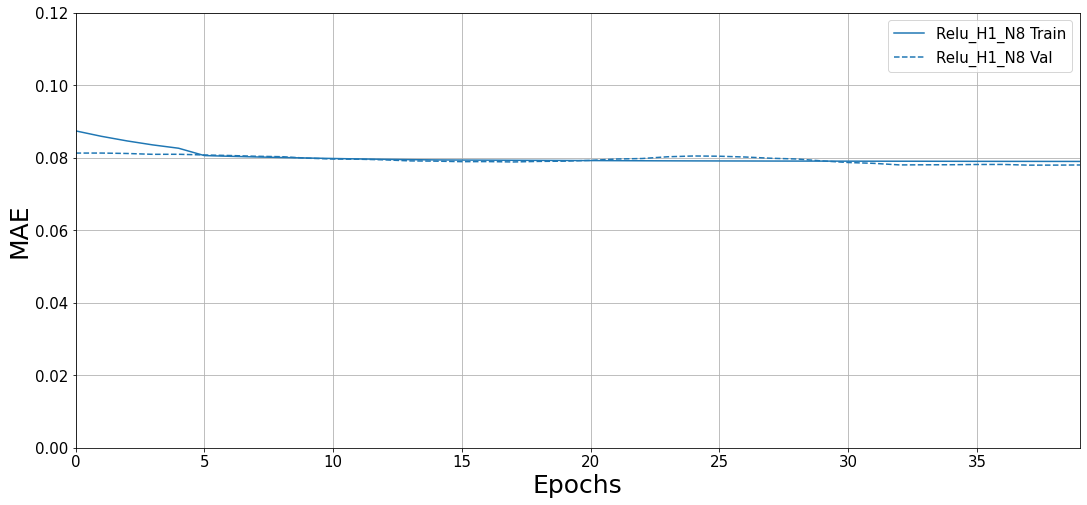

In [52]:
histories['ReLU_H1_n8'] = early_history1

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.0,0.12])
plt.ylabel('MAE')

In [53]:
nsize = 16
model2 = build_model(len(normed_train_data3.keys()),nsize,activ,learn)

early_history2 = model2.fit(normed_train_data3, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data3,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.0267,  mae:0.0933,  mse:0.0267,  val_loss:0.0168,  val_mae:0.0799,  val_mse:0.0168,  
.........................................

Text(0, 0.5, 'MAE')

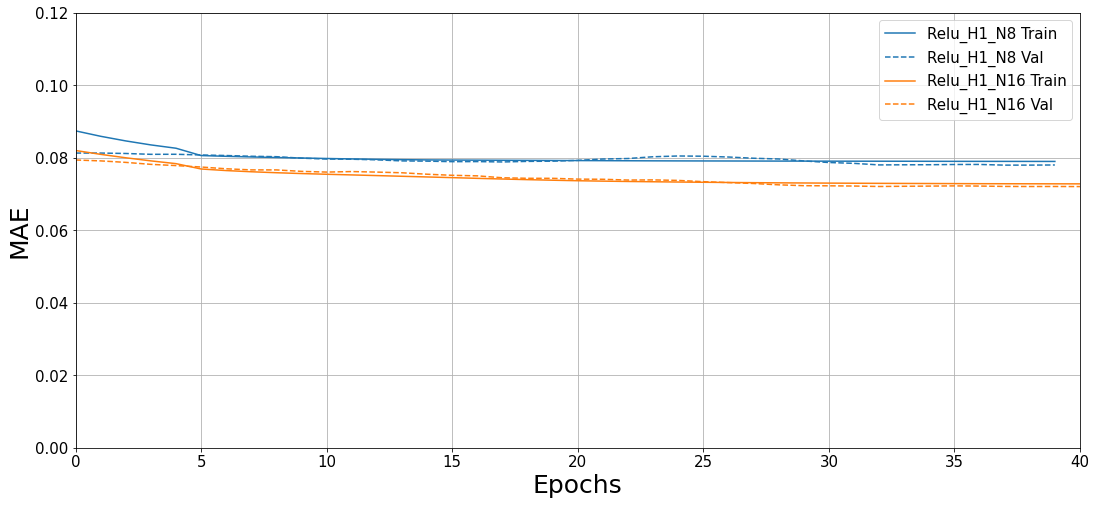

In [54]:
histories['ReLU_H1_n16'] = early_history2

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.0, 0.12])
plt.ylabel('MAE')

In [55]:
nsize = 8
activ = "ReLU_Adam_H2"
model3 = build_model(len(normed_train_data3.keys()),nsize,activ,learn)

early_history3 = model3.fit(normed_train_data3, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data3,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.0318,  mae:0.1005,  mse:0.0318,  val_loss:0.0179,  val_mae:0.0843,  val_mse:0.0179,  
.................

Text(0, 0.5, 'MAE')

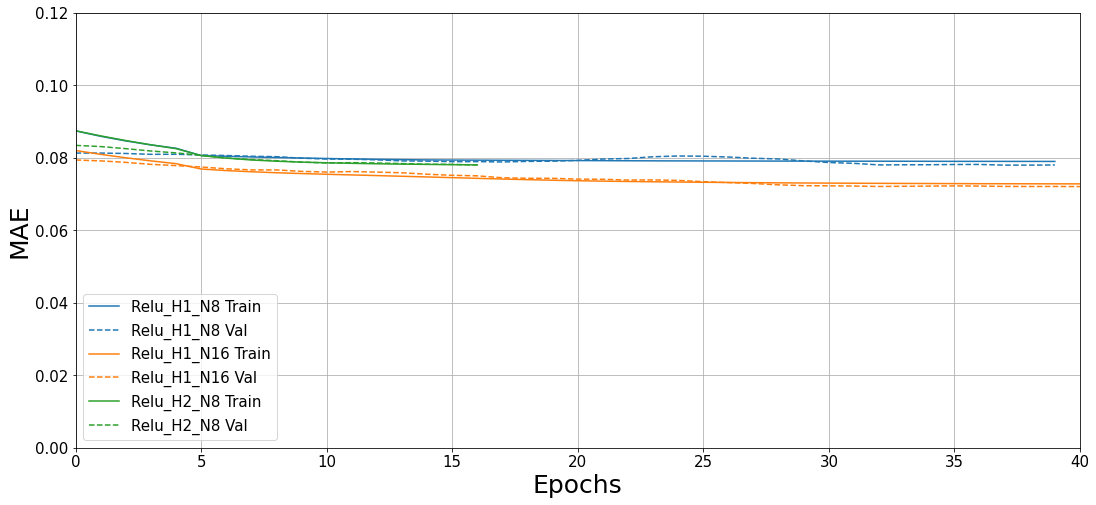

In [56]:
histories['ReLU_H2_n8'] = early_history3

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.0, 0.12])
plt.ylabel('MAE')

In [57]:
nsize = 16
activ = "ReLU_Adam_H2"
model4 = build_model(len(normed_train_data3.keys()),nsize,activ,learn)

early_history4 = model4.fit(normed_train_data3, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data3,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.0230,  mae:0.0877,  mse:0.0230,  val_loss:0.0163,  val_mae:0.0765,  val_mse:0.0163,  
...................................................

Text(0, 0.5, 'MAE')

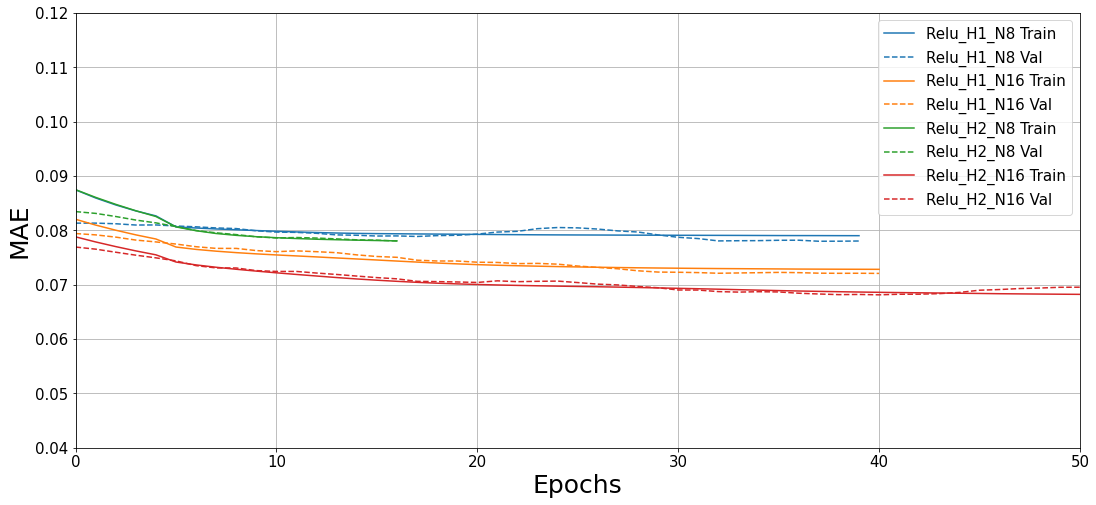

In [58]:
histories['ReLU_H2_n16'] = early_history4

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.04, 0.12])
plt.ylabel('MAE')

Text(0, 0.5, 'MSE')

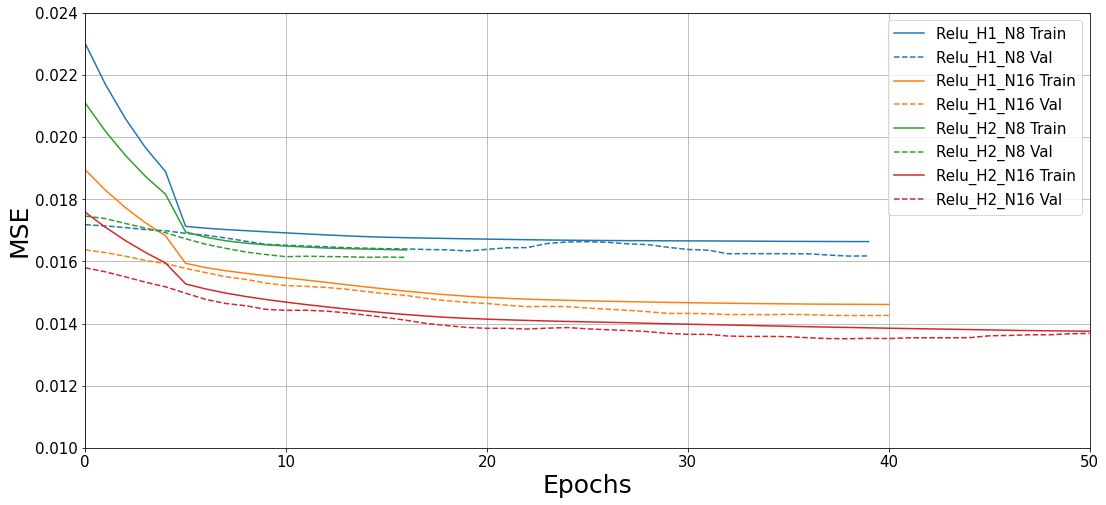

In [59]:
plotter.plot(histories, metric = "mse")
plt.ylim([0.01, 0.024])
plt.ylabel('MSE')

In [60]:
loss1, mae1, mse1 = model1.evaluate(normed_test_data3, normed_test_labels, verbose=2)

print("Testing set for model 1, Mean Abs Error: {:10.5f}".format(mae1))

209552/209552 - 6s - loss: 0.0163 - mae: 0.0775 - mse: 0.0163
Testing set for model 1, Mean Abs Error:    0.07748


In [61]:
loss2, mae2, mse2 = model2.evaluate(normed_test_data3, normed_test_labels, verbose=2)

print("Testing set for model 2, Mean Abs Error: {:20.5f}".format(mae2))

209552/209552 - 6s - loss: 0.0144 - mae: 0.0714 - mse: 0.0144
Testing set for model 2, Mean Abs Error:              0.07137


In [62]:
loss3, mae3, mse3 = model3.evaluate(normed_test_data3, normed_test_labels, verbose=2)

print("Testing set for model 3, Mean Abs Error: {:20.5f}".format(mae3))

209552/209552 - 5s - loss: 0.0163 - mae: 0.0782 - mse: 0.0163
Testing set for model 3, Mean Abs Error:              0.07816


In [63]:
loss4, mae4, mse4 = model4.evaluate(normed_test_data3, normed_test_labels, verbose=2)

print("Testing set for model 4, Mean Abs Error: {:20.5f}".format(mae4))

209552/209552 - 5s - loss: 0.0136 - mae: 0.0674 - mse: 0.0136
Testing set for model 4, Mean Abs Error:              0.06743


In [64]:
mae = [ mae1, mae2, mae3, mae4 ]
mae

[0.07747793, 0.0713724, 0.078157656, 0.0674336]

In [65]:
mse = [ mse1, mse2, mse3, mse4 ]
mse

[0.01625481, 0.014356472, 0.016271207, 0.013601298]

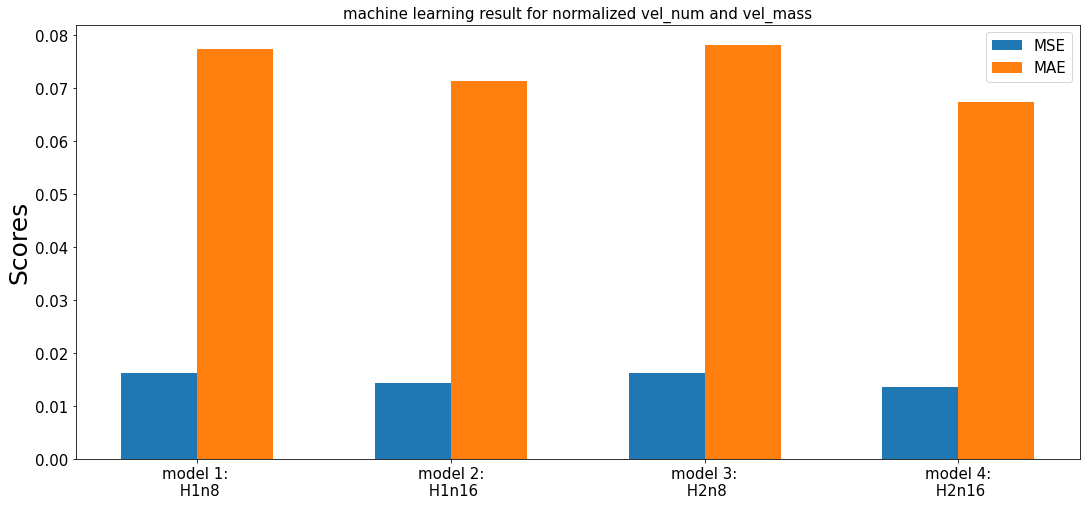

In [66]:
SMALL_SIZE = 15
MEDIUM_SIZE = 25
BIGGER_SIZE = 25

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

plt.rcParams["figure.figsize"] = (18,8)  # increase plot size

labels = ['model 1: \n H1n8',
 'model 2:\n H1n16',
 'model 3:\n H2n8',
 'model 4:\n H2n16' ]

x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, mse, width, label='MSE')
rects2 = ax.bar(x + width/2, mae, width, label='MAE')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('machine learning result for normalized vel_num and vel_mass')
ax.set_xticks(x)
ax.set_xticklabels(labels)
#ax.set_ylim(0,3e-8)
ax.legend()

#fig.tight_layout()

plt.show()

# Make predictions

Finally, predict the values using data in the testing set:

In [67]:
test_true_num  = np.exp(test_labels.pop('vel_num'))
test_true_mass = np.exp(test_labels.pop('vel_mass'))

In [68]:
def backtransform(x,stats):
  return x*stats['std']+stats['mean']

In [69]:
p1 = pd.DataFrame(data=model1.predict(normed_test_data3), columns=["vel_num", "vel_mass"])

In [70]:
p1.describe()

vel_num       vel_mass
count  209552.000000  209552.000000
mean        0.011738      -0.001637
std         0.998606       0.989133
min        -1.950246      -2.328605
25%        -0.859828      -0.786801
50%        -0.062380      -0.008355
75%         0.760711       0.800898
max         4.065698       3.256191

In [71]:
train_labels_stats

count      mean       std       min       25%       50%  \
vel_num   979504.0 -2.296182  0.422253 -2.999941 -2.666141 -2.331808   
vel_mass  979504.0 -2.005693  0.442072 -2.999339 -2.350725 -2.012157   

               75%       max  
vel_num  -1.974721 -0.606786  
vel_mass -1.653912 -0.600750

In [72]:
test_predict1 = np.exp(backtransform(p1,train_labels_stats))

In [73]:
test_predict1.describe()

vel_num       vel_mass
count  209552.000000  209552.000000
mean        0.110774       0.147769
std         0.049576       0.064425
min         0.044171       0.048070
25%         0.070001       0.095034
50%         0.098026       0.134071
75%         0.138765       0.191736
max         0.560218       0.567667

In [74]:
test_predict1_num  = test_predict1['vel_num']
test_predict1_mass = test_predict1['vel_mass']

In [75]:

p2 = pd.DataFrame(data=model1.predict(normed_test_data3), columns=["vel_num", "vel_mass"])

test_predict2 = np.exp(backtransform(p2,train_labels_stats))

test_predict2_num  = test_predict2['vel_num']
test_predict2_mass = test_predict2['vel_mass']

In [76]:

p3 = pd.DataFrame(data=model2.predict(normed_test_data3), columns=["vel_num", "vel_mass"])

test_predict3 = np.exp(backtransform(p3,train_labels_stats))

test_predict3_num  = test_predict3['vel_num']
test_predict3_mass = test_predict3['vel_mass']

In [77]:

p4 = pd.DataFrame(data=model3.predict(normed_test_data3), columns=["vel_num", "vel_mass"])

test_predict4 = np.exp(backtransform(p4,train_labels_stats))

test_predict4_num  = test_predict4['vel_num']
test_predict4_mass = test_predict4['vel_mass']

### Maybe the ordering of the arrays is different? 

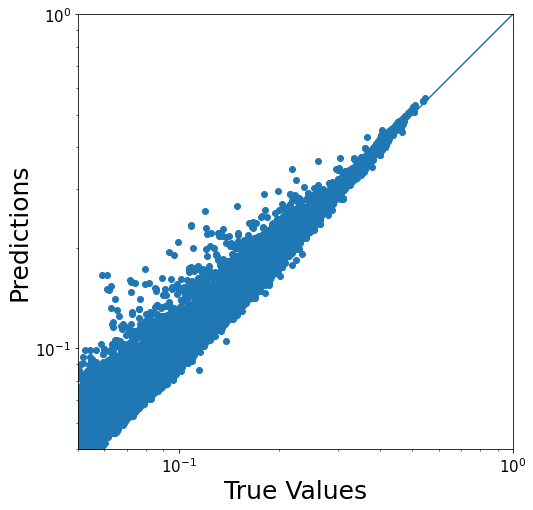

In [78]:
plt.rcParams["figure.figsize"] = (18,8)  # increase plot size

amin, amax = 5e-2, 1

a = plt.axes(aspect='equal')
plt.scatter(test_true_num, test_predict1_num)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

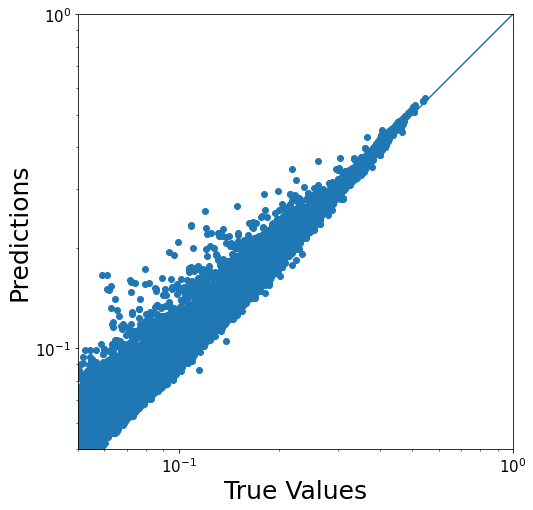

In [79]:
a = plt.axes(aspect='equal')
plt.scatter(test_true_num, test_predict2_num)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

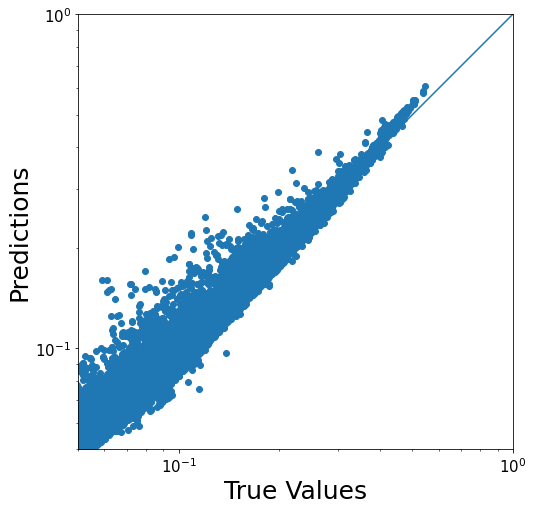

In [80]:
a = plt.axes(aspect='equal')
plt.scatter(test_true_num, test_predict3_num)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

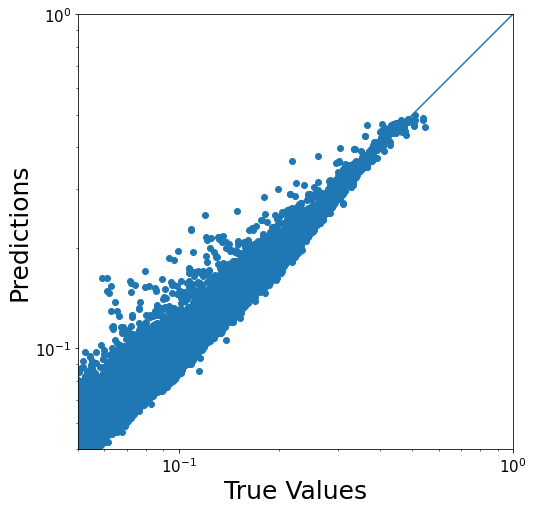

In [81]:
a = plt.axes(aspect='equal')
plt.scatter(test_true_num, test_predict4_num)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

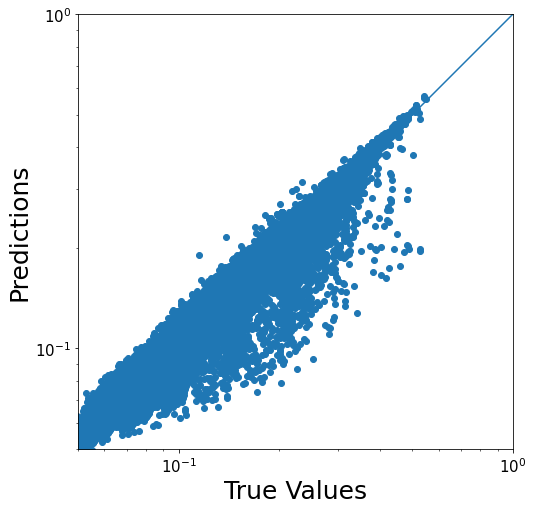

In [82]:
amin, amax = 5e-2, 1

a = plt.axes(aspect='equal')
plt.scatter(test_true_mass, test_predict1_mass)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

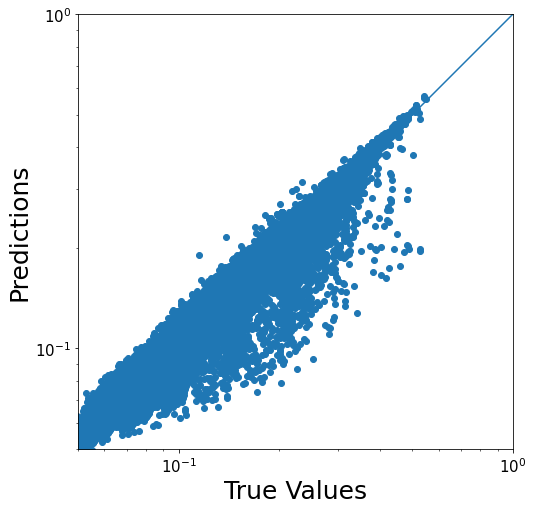

In [83]:
a = plt.axes(aspect='equal')
plt.scatter(test_true_mass, test_predict2_mass)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

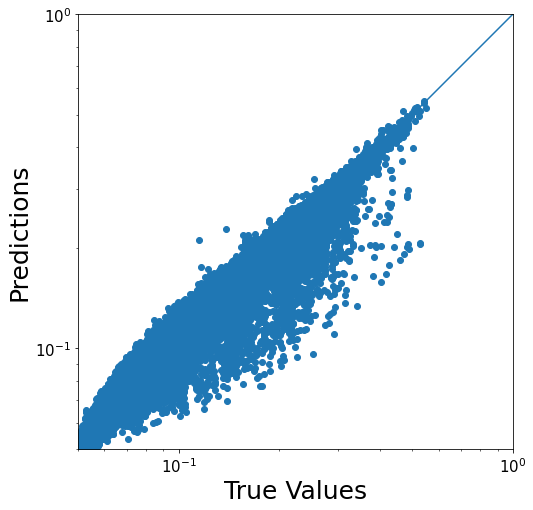

In [84]:
a = plt.axes(aspect='equal')
plt.scatter(test_true_mass, test_predict3_mass)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

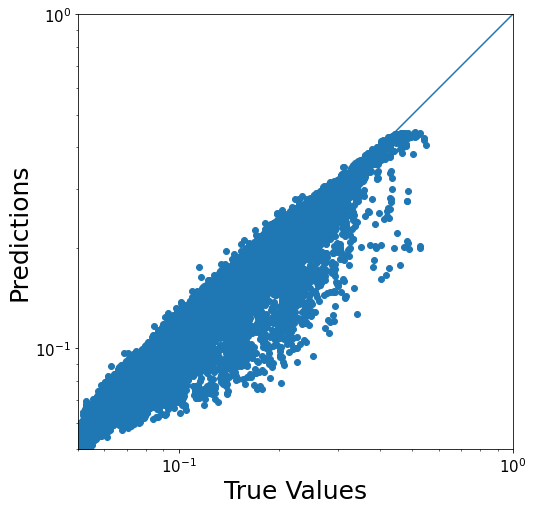

In [85]:
a = plt.axes(aspect='equal')
plt.scatter(test_true_mass, test_predict4_mass)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

# Save models to file

In [86]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model_v2
   

In [87]:
def save2netcdf(model, features_str, labels_str, features_norm, labels_norm, features_ltf, outpath, verbose=True):
    # borrowed from Fabian Jakub, LMU Munich
    # https://github.com/tenstream/tenstream/blob/master/misc/LUT_to_Keras.py

    if model is None:
        D = xr.Dataset()
        D.to_netcdf(outpath)
        return

    layers = [ l for l in model.layers if 'Dropout' not in str(type(l)) ]
    if verbose:
        print("Saving model to "+outpath)
        print("  Features:   "+features_str)
        print("  Labels:     "+labels_str)
        for i,l in enumerate(layers):
            print("  Layer {}: {}, {}, Activation: {}".format(i, str(type(l)), l.weights[0].shape,l.activation.__name__))

    D = xr.Dataset()
    D.attrs['Nlayer'] = np.int32(len(layers))
    D.attrs['features']  = features_str
    D.attrs['labels'] = labels_str
    D.attrs['keras_name'] = model.name

    for i, l in enumerate(layers):
        D["w{}".format(i)] = xr.DataArray(l.weights[0].numpy(), dims=("Ninp_{}".format(i), "Nout_{}".format(i)))
        D["b{}".format(i)] = xr.DataArray(l.weights[1].numpy(), dims=("Nout_{}".format(i)))
        D["w{}".format(i)].attrs['activation'] = l.activation.__name__

        
    # write arrays for logtransform and normalization of input and output data to netcdf
    nout = len(layers)-1
    D["inp_logtransform"] = xr.DataArray(features_ltf, dims=("Ninp_0"))
    D["inp_norm_mean"] = xr.DataArray(features_norm['mean'].values, dims=("Ninp_0"))
    D["inp_norm_std"]  = xr.DataArray(features_norm['std'].values, dims=("Ninp_0"))
    D["out_norm_mean"] = xr.DataArray(labels_norm['mean'].values, dims=("Nout_{}".format(nout)))
    D["out_norm_std"]  = xr.DataArray(labels_norm['std'].values, dims=("Nout_{}".format(nout)))
    
    D.to_netcdf(outpath)

In [88]:
features = 'qi, ni, temp, rho'
labels   = 'vel_ice_num, vel_ice_mass'
logtransform = np.array([True, True, False, False], dtype=bool)

save2netcdf(model1,features,labels,train_stats3,train_labels_stats,logtransform,'saved_model_v2/vel_ice_model1_'+version+'.nc')
save2netcdf(model2,features,labels,train_stats3,train_labels_stats,logtransform,'saved_model_v2/vel_ice_model2_'+version+'.nc')
save2netcdf(model3,features,labels,train_stats3,train_labels_stats,logtransform,'saved_model_v2/vel_ice_model3_'+version+'.nc')
save2netcdf(model4,features,labels,train_stats3,train_labels_stats,logtransform,'saved_model_v2/vel_ice_model4_'+version+'.nc')


Saving model to saved_model_v2/vel_ice_model1_17.nc
  Features:   qi, ni, temp, rho
  Labels:     vel_ice_num, vel_ice_mass
  Layer 0: <class 'tensorflow.python.keras.layers.core.Dense'>, (4, 8), Activation: relu
  Layer 1: <class 'tensorflow.python.keras.layers.core.Dense'>, (8, 8), Activation: relu
  Layer 2: <class 'tensorflow.python.keras.layers.core.Dense'>, (8, 2), Activation: linear
Saving model to saved_model_v2/vel_ice_model2_17.nc
  Features:   qi, ni, temp, rho
  Labels:     vel_ice_num, vel_ice_mass
  Layer 0: <class 'tensorflow.python.keras.layers.core.Dense'>, (4, 16), Activation: relu
  Layer 1: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: relu
  Layer 2: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 2), Activation: linear
Saving model to saved_model_v2/vel_ice_model3_17.nc
  Features:   qi, ni, temp, rho
  Labels:     vel_ice_num, vel_ice_mass
  Layer 0: <class 'tensorflow.python.keras.layers.core.Dense'>, (4, 8), Activation: re

In [89]:
activ = "ReLU_Adam_H1"
model = build_model(4,8,activ,1e-3)
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 8)                 40        
_________________________________________________________________
dense_18 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_19 (Dense)             (None, 2)                 18        
Total params: 130
Trainable params: 130
Non-trainable params: 0
_________________________________________________________________


In [90]:
activ = "ReLU_Adam_H1"
model = build_model(4,16,activ,1e-3)
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 16)                80        
_________________________________________________________________
dense_21 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_22 (Dense)             (None, 2)                 34        
Total params: 386
Trainable params: 386
Non-trainable params: 0
_________________________________________________________________


In [91]:
activ = "ReLU_Adam_H2"
model = build_model(4,8,activ,1e-3)
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_23 (Dense)             (None, 8)                 40        
_________________________________________________________________
dense_24 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_25 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_26 (Dense)             (None, 2)                 18        
Total params: 202
Trainable params: 202
Non-trainable params: 0
_________________________________________________________________


In [92]:
activ = "ReLU_Adam_H2"
model = build_model(4,16,activ,1e-3)
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             (None, 16)                80        
_________________________________________________________________
dense_28 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_29 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_30 (Dense)             (None, 2)                 34        
Total params: 658
Trainable params: 658
Non-trainable params: 0
_________________________________________________________________
